In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import shutil
from google.colab import files

Mounted at /content/drive/


In [27]:
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
import matplotlib.pyplot as plt
from matplotlib import animation, colors
from sklearn.metrics import accuracy_score #scoring

In [37]:
data = pd.read_csv("/content/drive/MyDrive/Wind_Pressure_ROI_points/Wind_Pressure_ROI.csv", header = None)
data = data.drop(0)
data.rename(columns = {450: "Name", 451: "Day"}, inplace = True)
data

<ipython-input-37-f1c668c7c8eb>:1: DtypeWarning: Columns (451) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/Wind_Pressure_ROI_points/Wind_Pressure_ROI.csv", header = None)


,0,1,2,3,4,5,6,7,8,9,...,442,443,444,445,446,447,448,449,Name,Day
1,0.904043,0.314050,0.904576,0.327869,0.904043,0.344262,0.900097,0.341667,0.896721,0.344262,...,0.894383,0.284615,0.904945,0.284615,0.914904,0.281250,0.925676,0.285714,3449_c9_cp2_29_58,3449
2,0.854847,0.471074,0.857352,0.475410,0.859717,0.483607,0.859649,0.491667,0.861968,0.483607,...,0.858377,0.307692,0.862218,0.307692,0.867308,0.312500,0.874035,0.317460,3450_c8_cp2_98_50,3450
3,0.886995,0.305785,0.881207,0.311475,0.876766,0.327869,0.872807,0.333333,0.872736,0.336066,...,0.909265,0.292308,0.915506,0.300000,0.921154,0.304688,0.926641,0.301587,3450_c8_cp3_59_56,3450
4,0.861179,0.454545,0.864167,0.475410,0.866050,0.500000,0.867446,0.508333,0.871268,0.516393,...,0.872300,0.330769,0.875660,0.330769,0.881731,0.328125,0.889479,0.333333,3451_c8_cp2_99_50,3451
5,0.915246,0.247934,0.914800,0.270492,0.915246,0.295082,0.915205,0.316667,0.919236,0.327869,...,0.939990,0.300000,0.943831,0.300000,0.946154,0.296875,0.952220,0.293651,3452_c8_cp3_55_59,3452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,0.672187,0.355372,0.668452,0.360656,0.665855,0.377049,0.662768,0.375000,0.662261,0.377049,...,0.722516,0.576923,0.730197,0.569231,0.738462,0.562500,0.747587,0.555556,1648_c3_cp2_15_28,1648
3649,0.950804,0.404959,0.950341,0.418033,0.953726,0.434426,0.954191,0.441667,0.957416,0.442623,...,0.934710,0.284615,0.939030,0.276923,0.941827,0.273438,0.946911,0.261905,1648_c9_cp3_65_62,1648
3650,0.918169,0.471074,0.925998,0.500000,0.932294,0.532787,0.938596,0.550000,0.945179,0.549180,...,0.935670,0.446154,0.935670,0.438462,0.936538,0.437500,0.937741,0.428571,1649_c11_cp1_61_51,1649
3651,0.621042,0.264463,0.622201,0.270492,0.623965,0.286885,0.625731,0.291667,0.628977,0.295082,...,0.674028,0.576923,0.683629,0.561538,0.694712,0.546875,0.707529,0.523810,1649_c3_cp2_16_25,1649


In [4]:
pressure_training_data_path = "/content/drive/MyDrive/First2YearRawAndNormData/CESMZ200/MinMaxNormWithLabel"
CL_path = pressure_training_data_path + "/CL"
COH_path = pressure_training_data_path + "/COH"
COL_path = pressure_training_data_path + "/COL"
NROI_path = pressure_training_data_path + "/NROI"


In [5]:
pressure_CL_files = [f for f in os.listdir(CL_path) if f.endswith('.csv')]
pressure_COH_files = [f for f in os.listdir(COH_path) if f.endswith('.csv')]
pressure_COL_files = [f for f in os.listdir(COL_path) if f.endswith('.csv')]
pressure_NROI_files = [f for f in os.listdir(NROI_path) if f.endswith('.csv')]


In [6]:
pressure_array = []
for file in pressure_CL_files:
    dataframe = pd.read_csv(os.path.join(CL_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    pressure_array.append(dataframe)

for file in pressure_COH_files:
    dataframe = pd.read_csv(os.path.join(COH_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    pressure_array.append(dataframe)

for file in pressure_COL_files:
    dataframe = pd.read_csv(os.path.join(COL_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    pressure_array.append(dataframe)

for file in pressure_NROI_files:
    dataframe = pd.read_csv(os.path.join(NROI_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    pressure_array.append(dataframe)


In [7]:
pressure_training_df = pd.DataFrame(pressure_array)
Y = []
for i in range(len(pressure_CL_files)):
  Y.append(0)

for i in range(len(pressure_COH_files)):
  Y.append(1)

for i in range(len(pressure_COL_files)):
  Y.append(2)

for i in range(len(pressure_NROI_files)):
  Y.append(3)

Y = pd.DataFrame(Y)

In [10]:
wind_training_data_path = "/content/drive/MyDrive/First2YearRawAndNormData/CESMU200/MinMaxNormWithLabel"
wind_CL_path = wind_training_data_path + "/CL"
wind_COH_path = wind_training_data_path + "/COH"
wind_COL_path = wind_training_data_path + "/COL"
wind_NROI_path = wind_training_data_path + "/NROI"

In [11]:
CL_wind_files = [f for f in os.listdir(wind_CL_path) if f.endswith(".csv")]
COH_wind_files = [f for f in os.listdir(wind_COH_path) if f.endswith(".csv")]
COL_wind_files = [f for f in os.listdir(wind_COL_path) if f.endswith(".csv")]
NROI_wind_files = [f for f in os.listdir(wind_NROI_path) if f.endswith(".csv")]

In [12]:
wind_array = []
for file in CL_wind_files:
    dataframe = pd.read_csv(os.path.join(CL_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    wind_array.append(dataframe)

for file in COH_wind_files:
    dataframe = pd.read_csv(os.path.join(COH_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    wind_array.append(dataframe)

for file in COL_wind_files:
    dataframe = pd.read_csv(os.path.join(COL_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    wind_array.append(dataframe)

for file in NROI_wind_files:
    dataframe = pd.read_csv(os.path.join(NROI_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    wind_array.append(dataframe)


In [13]:
wind_training_df = pd.DataFrame(wind_array)

In [16]:
#Combine the data
df_array = np.stack((np.array(pressure_training_df), np.array(wind_training_df)), axis = 2)

#Reshape the data
(h, w, c) = df_array.shape
reshape_df_array = df_array.reshape(h, w*c)
training_df = pd.DataFrame(reshape_df_array)

In [38]:
#Define training and testing data
X_train = training_df
Y_train = Y

X_test = data.drop(columns = ["Name", "Day"])

In [21]:
#Normalization
def minmax_scaler(data):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    return scaled

#Euclidean distance
def e_distance(x, y):
    return distance.euclidean(x, y)

#Manhanttan distance
def m_distance(x, y):
    return distance.cityblock(x, y)

#Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance:
        shortest_distance = distance
        winner = [row,col]
  return winner

#Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range


In [29]:
num_rows = 15
num_cols = 15
max_m_dsitance = 10
max_learning_rate = 0.75
max_steps = 100000

In [30]:
#main function

train_x_norm = minmax_scaler(X_train) # normalisation
# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
#np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

  t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  for row in range(num_rows):
    for col in range(num_cols):
      if m_distance([row,col],winner) <= neighbourhood_range:
        som[row][col] += learning_rate*(train_x_norm[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
Iteration:  21000
Iteration:  22000
Iteration:  23000
Iteration:  24000
Iteration:  25000
Iteration:  26000
Iteration:  27000
Iteration:  28000
Iteration:  29000
Iteration:  30000
Iteration:  31000
Iteration:  32000
Iteration:  33000
Iteration:  34000
Iteration:  35000
Iteration:  36000
Iteration:  37000
Iteration:  38000
Iteration:  39000
Iteration:  40000
Iteration:  41000
Iteration:  42000
Iteration:  43000
Iteration:  44000
Iteration:  45000
Iteration:  46000
Iteration:  47000
Iteration:  48000
Iteration:  49000
Iteration:  50000
Iteration:  51000
Iteration:  52000
Iteration:  53000
Iteration:  54000
Iteration:  55000
Iteration:  56000
I

In [31]:
label_data = np.array(Y_train)
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
  if (t+1) % 1000 == 0:
    print("sample data: ", t+1)
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

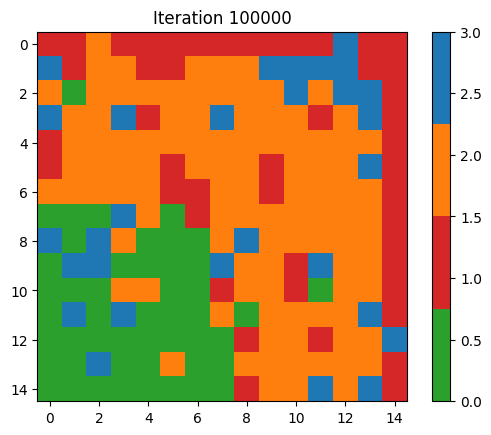

In [32]:
# construct label map
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 3
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange', 'tab:blue'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

In [39]:
testing_data = minmax_scaler(X_test)

winner_labels = []

for t in range(testing_data.shape[0]):
  winner = winning_neuron(testing_data, t, som, num_rows, num_cols)
  row = winner[0]
  col = winner[1]
  predicted = label_map[row][col]
  winner_labels.append(predicted)



In [40]:
data["Class"] = winner_labels
data

,0,1,2,3,4,5,6,7,8,9,...,443,444,445,446,447,448,449,Name,Day,Class
1,0.904043,0.314050,0.904576,0.327869,0.904043,0.344262,0.900097,0.341667,0.896721,0.344262,...,0.284615,0.904945,0.284615,0.914904,0.281250,0.925676,0.285714,3449_c9_cp2_29_58,3449,3
2,0.854847,0.471074,0.857352,0.475410,0.859717,0.483607,0.859649,0.491667,0.861968,0.483607,...,0.307692,0.862218,0.307692,0.867308,0.312500,0.874035,0.317460,3450_c8_cp2_98_50,3450,2
3,0.886995,0.305785,0.881207,0.311475,0.876766,0.327869,0.872807,0.333333,0.872736,0.336066,...,0.292308,0.915506,0.300000,0.921154,0.304688,0.926641,0.301587,3450_c8_cp3_59_56,3450,3
4,0.861179,0.454545,0.864167,0.475410,0.866050,0.500000,0.867446,0.508333,0.871268,0.516393,...,0.330769,0.875660,0.330769,0.881731,0.328125,0.889479,0.333333,3451_c8_cp2_99_50,3451,2
5,0.915246,0.247934,0.914800,0.270492,0.915246,0.295082,0.915205,0.316667,0.919236,0.327869,...,0.300000,0.943831,0.300000,0.946154,0.296875,0.952220,0.293651,3452_c8_cp3_55_59,3452,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,0.672187,0.355372,0.668452,0.360656,0.665855,0.377049,0.662768,0.375000,0.662261,0.377049,...,0.576923,0.730197,0.569231,0.738462,0.562500,0.747587,0.555556,1648_c3_cp2_15_28,1648,2
3649,0.950804,0.404959,0.950341,0.418033,0.953726,0.434426,0.954191,0.441667,0.957416,0.442623,...,0.284615,0.939030,0.276923,0.941827,0.273438,0.946911,0.261905,1648_c9_cp3_65_62,1648,1
3650,0.918169,0.471074,0.925998,0.500000,0.932294,0.532787,0.938596,0.550000,0.945179,0.549180,...,0.446154,0.935670,0.438462,0.936538,0.437500,0.937741,0.428571,1649_c11_cp1_61_51,1649,3
3651,0.621042,0.264463,0.622201,0.270492,0.623965,0.286885,0.625731,0.291667,0.628977,0.295082,...,0.576923,0.683629,0.561538,0.694712,0.546875,0.707529,0.523810,1649_c3_cp2_16_25,1649,2


In [44]:
ROI = {}
data_frame = data.to_numpy()
for item in data_frame:
    part = item[450].split("_")
    day = int(part[0])
    x = int(part[3])
    y = int(part[4])
    category = item[452]
    if day in ROI:
        ROI[day].append([x, y, category])
    else:
        ROI[day] = [[x, y, category]]


In [45]:
folder_name = "Categorical_Wind_Pressure_ROI_Image"
folder_path = "/content/drive/MyDrive/" + folder_name

os.makedirs(folder_path)

In [46]:
image_path = "/content/drive/MyDrive/Pressure_raw_Image"
color_list = {0: (0, 255, 0), 1: (0, 0, 255), 2: (0, 255, 255), 3: (255, 0, 0)}
for file in os.listdir(image_path):
    file_path = os.path.join(image_path, file)
    final_img = cv2.imread(file_path)

    file_name = os.path.splitext(file)[0]
    number = int(file_name[3:])

    if number in ROI:
        for point in ROI[number]:
            x = point[0]
            y = point[1]
            color = color_list[point[2]]

            size = 2

            vertices = np.array([(x, y - size), (x - size, y), (x, y + size), (x + size, y)])

            cv2.drawContours(final_img, [vertices.reshape((-1, 1, 2))], -1, color, thickness = cv2.FILLED)

        cv2.imwrite(folder_path + "/day" + str(number) + ".png", final_img)